In [27]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

**Initialize the parameters**

In [33]:
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4   # Non-maximum suppression threshold
inpWidth = 416       # Width of network's input image
inpHeight = 416      # Height of network's input image

class Args(object):
    def __init__(self, **params):
#         self.image = params.get('image', '../Mask_RCNN_Advance/images/39952054_2246726052008225_4303734629921193984_o.jpg')
        self.image = params.get('image', 'bird.jpg')
        self.video = params.get('video', 'run.mp4')

args = Args()        
print (args.image, args.video)

bird.jpg run.mp4


**Load names of classes**

In [34]:
classesFile = "coco.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg";
modelWeights = "yolov3.weights";

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

**Define functions**

In [35]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)

**Process inputs**

In [36]:
winName = 'Deep learning object detection in OpenCV'
# cv.namedWindow(winName, cv.WINDOW_NORMAL)
print(winName)

outputFile = "yolo_out_py.avi"
if (args.image):
    # Open the image file
    if not os.path.isfile(args.image):
        print("Input image file ", args.image, " doesn't exist")
        sys.exit(1)
    cap = cv.VideoCapture(args.image)
    outputFile = args.image[:-4]+'_yolo_out_py.jpg'
elif (args.video):
    # Open the video file
    if not os.path.isfile(args.video):
        print("Input video file ", args.video, " doesn't exist")
        sys.exit(1)
    cap = cv.VideoCapture(args.video)
    outputFile = args.video[:-4]+'_yolo_out_py.avi'
else:
    # Webcam input
    cap = cv.VideoCapture(0)

# Get the video writer initialized to save the output video
if (not args.image):
    vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'), 30, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))


Deep learning object detection in OpenCV


**Process each frame**

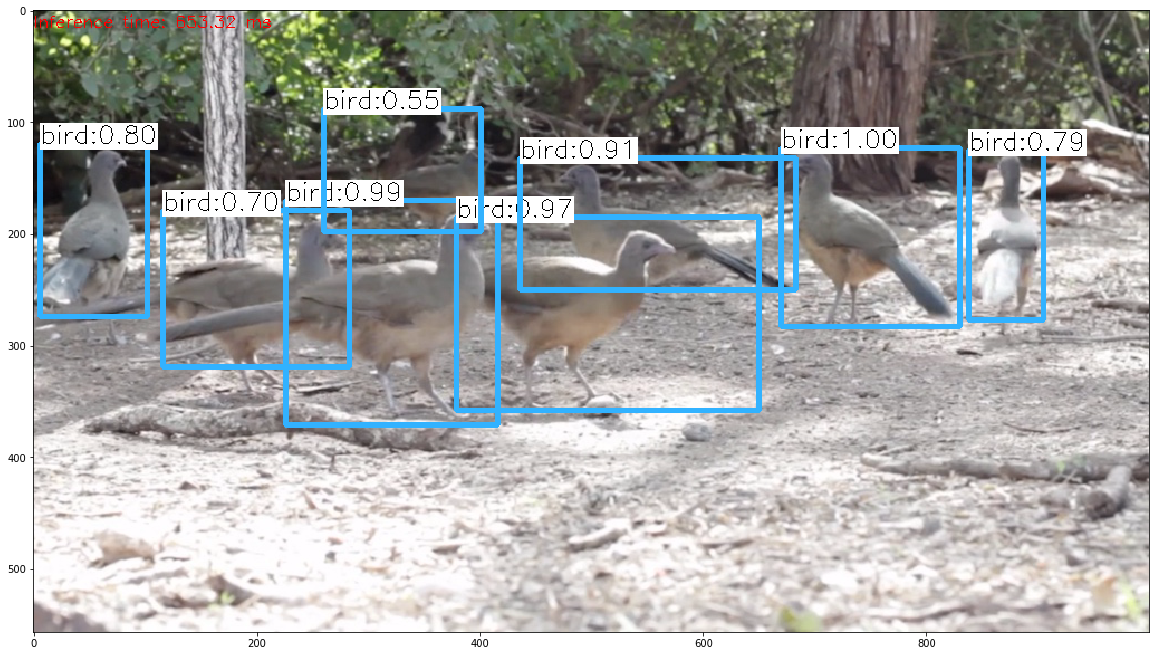

Done processing !!!
Output file is stored as  bird_yolo_out_py.jpg
Done processing


In [37]:
try:
    while True:
    
        # get frame from the video
        hasFrame, frame = cap.read()

        # Stop the program if reached end of video
        if not hasFrame:
            print("Done processing !!!")
            print("Output file is stored as ", outputFile)
            cv.waitKey(3000)
            # Release device
            cap.release()
            break

        # Create a 4D blob from a frame.
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        postprocess(frame, outs)

        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

        # Write the frame with the detection boxes
        if (args.image):
            cv.imwrite(outputFile, frame.astype(np.uint8));
        else:
            vid_writer.write(frame.astype(np.uint8))

        # matplot as background so we can draw one by one
        # to break the loop, press ESC, then I twice   
        plt.figure(figsize=(20,15))        
        plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB), animated=True)
        plt.show()
        
except KeyboardInterrupt:
    print ('Stop processing')
    pass

print ('Done processing')